# Colombia seimic global stats
(1st June, 1993 to 31st May, 2023)

In [1]:
import folium
import numpy as np
import pandas as pd
from pytz import timezone
import matplotlib.pyplot as plt

## Data source 

The data was downloaded form Servicio geológico colombiano, http://bdrsnc.sgc.gov.co/paginas1/catalogo/index.php and splited in 14 files: "reporte???.xlsx" and then cleaned by using the notebook in:

https://github.com/suarez-duran-m/personal_projects/blob/main/seismic/seismic_global_stats.ipynb

In [2]:
data_seismic = pd.read_excel('data/seismic_1st_jan_93_to_31st_may_23.xlsx')

In [3]:
data_seismic.head()

,LAT,LONG,PROF.,MAGNITUD,DEPARTAMENTO,MUNICIPIO,ERR-LAT,ERR-LONG,ERR-PROF,ESTADO,FECHA - HORA UTC
0,6.798,-73.099,143.5,1.5,SANTANDER,LOS SANTOS,7.1,7.0,8.5,Revisado,2017-01-01 00:56:54
1,6.749,-73.169,150.0,1.4,SANTANDER,LOS SANTOS,4.9,4.5,5.8,Revisado,2017-01-01 01:32:32
2,6.772,-73.119,144.5,1.9,SANTANDER,LOS SANTOS,3.7,4.3,6.1,Revisado,2017-01-01 01:44:47
3,6.803,-73.139,145.1,2.0,SANTANDER,LOS SANTOS,3.0,3.0,4.3,Revisado,2017-01-01 01:51:27
4,6.777,-73.116,143.5,1.6,SANTANDER,LOS SANTOS,5.5,5.5,6.4,Revisado,2017-01-01 02:45:22


## Seismic geolocalization 

Filtering seismic by magnitude

In [35]:
data_filtered_long = data_seismic[data_seismic['LONG'] > -77.6]

# Filter events with magnitude between 5.0 and 5.5
seismic_magBig_5_55 = data_filtered_long[(data_filtered_long['MAGNITUD'] >= 5.) & (data_filtered_long['MAGNITUD'] < 5.5)]
# Filter events with magnitude between 5.5 and 6.0
seismic_magBig_55_6 = data_filtered_long[(data_filtered_long['MAGNITUD'] >= 5.5) & (data_filtered_long['MAGNITUD'] < 6.0)]
# Filter events with magnitude between 5.5 and 6.0
seismic_magBig_6 = data_filtered_long[(data_filtered_long['MAGNITUD'] >= 6) & (data_filtered_long['PROF.'] > 100)]

#Filter eventts with magnitude bigger than 5.0
seismic_magBig_5 = data_filtered_long[(data_filtered_long['MAGNITUD'] >= 5)]

### Locating seismic on map

In [5]:
# Create a map centered on a specific location
map = folium.Map(location=[seismic_magBig_6['LAT'].mean(), seismic_magBig_6['LONG'].mean()], zoom_start=6)

# Add markers for each event
for _, row in seismic_magBig_5_55.iterrows():
    folium.Marker(
        location=[row['LAT'], row['LONG']],
        popup=f"Magnitude: {row['MAGNITUD']}<br>Municipio: {row['MUNICIPIO']}<br>Date: {row['FECHA - HORA UTC']}<br>Prof.: {row['PROF.']}",
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map)
    
for _, row in seismic_magBig_55_6.iterrows():
    folium.Marker(
        location=[row['LAT'], row['LONG']],
        popup=f"Magnitude: {row['MAGNITUD']}<br>Municipio: {row['MUNICIPIO']}<br>Date: {row['FECHA - HORA UTC']}<br>Prof.: {row['PROF.']}",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(map)
    
for _, row in seismic_magBig_6.iterrows():
    folium.Marker(
        location=[row['LAT'], row['LONG']],
        popup=f"Magnitude: {row['MAGNITUD']}<br>Municipio: {row['MUNICIPIO']}<br>Date: {row['FECHA - HORA UTC']}<br>Prof.: {row['PROF.']}",
        icon=folium.Icon(color='black', icon='info-sign')
    ).add_to(map)
    

# Display the map
map.save('map.html')  # Save the map as an HTML file

## Checking for correlation between seismic and temperature 

### Data collection 

The temperature measurements was collected from "Colombia, datos abiertos":  
https://www.datos.gov.co/Ambiente-y-Desarrollo-Sostenible/temperatura-bucaramanga/7zu2-qewy



In [156]:
data_temp = pd.read_csv('data/temperatura_bucaramanga.csv')
data_temp.head(3)

,CodigoEstacion,CodigoSensor,FechaObservacion,ValorObservado,NombreEstacion,Departamento,Municipio,ZonaHidrografica,Latitud,Longitud,DescripcionSensor,UnidadMedida
0,23195230,68,01/21/2020 02:00:00 PM,28.6,NEOMUNDO - AUT,SANTANDER,BUCARAMANGA,MEDIO MAGDALENA,7.102611,-73.107306,Temp Aire 2 m,°C
1,23195230,68,01/21/2020 08:00:00 PM,22.7,NEOMUNDO - AUT,SANTANDER,BUCARAMANGA,MEDIO MAGDALENA,7.102611,-73.107306,Temp Aire 2 m,°C
2,23195230,68,01/21/2020 09:00:00 PM,22.7,NEOMUNDO - AUT,SANTANDER,BUCARAMANGA,MEDIO MAGDALENA,7.102611,-73.107306,Temp Aire 2 m,°C


### Checking for NaN values

In [193]:
# Changin column name
data_temp.rename(columns={'ValorObservado': 'Temperature'}, inplace=True)

print(data_temp.isna().sum())

CodigoEstacion       0
CodigoSensor         0
FechaObservacion     0
Temperature          0
NombreEstacion       0
Departamento         0
Municipio            0
ZonaHidrografica     0
Latitud              0
Longitud             0
DescripcionSensor    0
UnidadMedida         0
dtype: int64


Filtering by FechaObservacion and ValorObservado, and converting to *datatime* format

In [215]:
tmp_temp = data_temp[['FechaObservacion', 'Temperature']].copy()
tmp_temp['Date'] = pd.to_datetime(tmp_temp['FechaObservacion'], format='%m/%d/%Y %I:%M:%S %p')
tmp_temp.drop(columns='FechaObservacion', inplace=True)

print(tmp_temp.isna().sum(), '\n', tmp_temp.size)
tmp_temp.set_index('Date', inplace=True)
temp_daily_avg = tmp_temp.resample('D').mean()
temp_daily_avg = temp_daily_avg.reset_index()
temp_daily_avg.head(3)

Temperature    0
Date           0
dtype: int64 
 165220


,Date,Temperature
0,2005-07-26,18.400000
1,2005-07-27,17.275000
2,2005-07-28,17.717391


In [218]:
#tmp_temp.reset_index(inplace=True)
tmp = tmp_temp[tmp_temp['Date'].dt.date == pd.to_datetime('2005-07-28').date()]

In [219]:
print(tmp)
print("\n", "Ave. Temperature:", tmp['Temperature'].mean())

                     Date  Temperature
2585  2005-07-28 23:00:00         15.8
3105  2005-07-28 16:00:00         20.2
7738  2005-07-28 09:00:00         18.7
8210  2005-07-28 20:00:00         17.3
9337  2005-07-28 11:00:00         18.8
9349  2005-07-28 17:00:00         19.4
14455 2005-07-28 05:00:00         14.7
16065 2005-07-28 00:00:00         16.1
16888 2005-07-28 19:00:00         17.9
18120 2005-07-28 06:00:00         14.8
20269 2005-07-28 21:00:00         16.7
20502 2005-07-28 01:00:00         15.6
23322 2005-07-28 08:00:00         15.6
23654 2005-07-28 14:00:00         22.5
24033 2005-07-28 02:00:00         15.4
26893 2005-07-28 15:00:00         21.1
26987 2005-07-28 13:00:00         22.4
29328 2005-07-28 12:00:00         21.1
32560 2005-07-28 10:00:00         17.9
37020 2005-07-28 04:00:00         15.3
37385 2005-07-28 03:00:00         15.4
40135 2005-07-28 22:00:00         16.3
57939 2005-07-28 18:00:00         18.5

 Ave. Temperature: 17.717391304347824


Do it for seismic, where we are averaging the seismic magnituded

In [141]:
tmp_seismic_day = data_seismic[['FECHA - HORA UTC', 'MAGNITUD']].copy()
tmp_seismic_day['Date'] = pd.to_datetime(tmp_seismic_day['FECHA - HORA UTC'], format='%Y-%m-%d %H:%M:%S')
tmp_seismic_day.drop(columns='FECHA - HORA UTC', inplace=True)

tmp_seismic_day.set_index('Date', inplace=True)
tmp_seismic_day.reset_index(inplace=True)

seismic_day = tmp_seismic_day.copy()
seismic_day['Date'] = pd.to_datetime(seismic_day['Date']).dt.date
seismic_day['Date'] = pd.to_datetime(seismic_day['Date'])

'''
tmp_seismic_day.set_index('Date', inplace=True)
seismic_day = tmp_seismic_day.resample('D').mean()
seismic_day = seismic_day.reset_index()
'''
seismic_day.head(3)

,Date,MAGNITUD
0,2017-01-01,1.5
1,2017-01-01,1.4
2,2017-01-01,1.9


In [142]:
tmp_seismic_day = seismic_magBig_5[['FECHA - HORA UTC', 'MAGNITUD']].copy()
tmp_seismic_day['Date'] = pd.to_datetime(tmp_seismic_day['FECHA - HORA UTC'], format='%Y-%m-%d %H:%M:%S')
tmp_seismic_day.drop(columns='FECHA - HORA UTC', inplace=True)
tmp_seismic_day.set_index('Date', inplace=True)
tmp_seismic_day.reset_index(inplace=True)

seismic_day_magBig_5 = tmp_seismic_day.copy()
seismic_day_magBig_5['Date'] = pd.to_datetime(seismic_day_magBig_5['Date']).dt.date
seismic_day_magBig_5['Date'] = pd.to_datetime(seismic_day_magBig_5['Date'])

seismic_day_magBig_5.head(3)

,Date,MAGNITUD
0,2017-02-06,5.3
1,2017-02-12,5.0
2,2017-10-01,5.4


Merging the data

In [143]:
df3 = temp_daily_avg.merge(seismic_day, on='Date', how='inner')
df4 = temp_daily_avg.merge(seismic_day, on='Date', how='outer')

df5 = temp_daily_avg.merge(seismic_day_magBig_5, on='Date', how='inner')

In [144]:
print(df3.size)
df3.head(3)

732738


,Date,Temperature,MAGNITUD
0,2005-07-26,18.4,2.1
1,2005-07-26,18.4,2.4
2,2005-07-26,18.4,1.9


In [145]:
print(df4.size)
df4.head(3)

879708


,Date,Temperature,MAGNITUD
0,2005-07-26,18.4,2.1
1,2005-07-26,18.4,2.4
2,2005-07-26,18.4,1.9


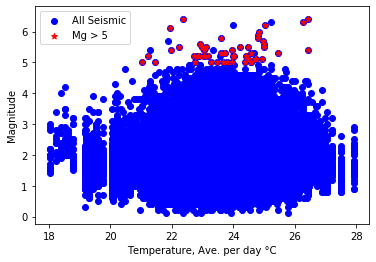

In [176]:
df_filt = df5[(df5['Temperature'] > 18)]
df_filt2 = df3[(df3['Temperature'] > 18)]

plt.scatter(df_filt2['Temperature'], df_filt2['MAGNITUD'], color='blue', label='All Seismic')
plt.scatter(df_filt['Temperature'], df_filt['MAGNITUD'], color='red', marker='*', label='Mg > 5')

plt.xlabel('Temperature, Ave. per day °C')
plt.ylabel('Magnitude')
plt.legend()

plt.show()

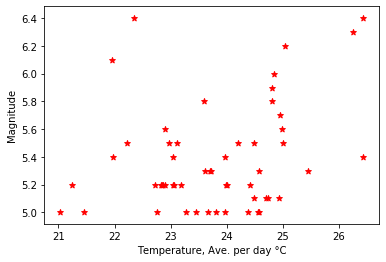

In [174]:
plt.scatter(df_filt['Temperature'], df_filt['MAGNITUD'], color='red', marker='*', label='Mg > 5')

plt.xlabel('Temperature, Ave. per day °C')
plt.ylabel('Magnitude')

plt.show()